In [2]:
# Bibliotecas

import paho.mqtt.client as mqtt
import time
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Funções

def data_sender(irrigacao, semeadura):
    client = mqtt.Client()

    def on_connect(client, userdata, flags, rc):
        print("Conectado com código de resultado: " + str(rc))
        client.subscribe("GrupoZ_irrigacao")
        client.publish("GrupoZ_irrigacao", irrigacao, retain=True)
        client.subscribe("GrupoZ_semeadura")
        client.publish("GrupoZ_semeadura", semeadura, retain=True)
        
    client.on_connect = on_connect

    broker_address = "broker.hivemq.com"
    port = 1883
    username = "dadosClimaticosGrupoZ"
    password = ""
    
    client.username_pw_set(username, password)
    client.connect(broker_address, port, 60)

    try:    
        client.loop_start()
        time.sleep(2)
    except:
        client.disconnect()
        raise Exception("Desconectando...")
        

def salvar_para_csv(dados):
    with open('dadosClimaticosGrupoZ.csv', 'a', newline='\n') as arquivo_csv:
        arquivo_csv.write(dados + '\n')
    print("Dados salvos no arquivo CSV com sucesso!")

def data_treatment(dados):
    salvar_para_csv(dados)
    dados_list = dados.split(';')

    temperatura = float(dados_list[1])
    umidade = float(dados_list[2])

    irrigacao = "1" if (20 < temperatura < 30) and (50 < umidade < 70) else "0" #50-70
    semeadura = "1" if (15 < temperatura < 30) and (60 < umidade < 70) else "0" #60-70

    data_sender(irrigacao, semeadura)

def data_reader():
    client = mqtt.Client()
    
    broker_address = "broker.hivemq.com"
    port = 1883
    username = "dadosClimaticosGrupoZ"
    password = ""

    def on_connect(client, userdata, flags, rc):
        print("Conectado com código de resultado: " + str(rc))
        client.subscribe("GrupoZ_time_temp_umi_press_alt")

    def on_message(client, userdata, msg):
        print("Mensagem recebida no tópico {}: {}".format(msg.topic, msg.payload.decode()))
        data_treatment(msg.payload.decode())

    client.on_connect = on_connect
    client.on_message = on_message

    client.username_pw_set(username, password)
    client.connect(broker_address, port, 60)

    try:
        client.loop_forever()
    except:
        client.disconnect()
        raise Exception("Desconectando...")

In [20]:
# Coleta de dados

with open('dadosClimaticosGrupoZ.csv', 'w', newline='\n') as arquivo_csv:
    arquivo_csv.write("Timestamp;Temperatura;Umidade;Pressao;Altitude\n")

print("Encerre a execução da célula para parar de coletar dados!")
try:
    data_reader()
except:
    print("Conexão com o broker encerrada!")

Encerre a execução da célula para parar de coletar dados!
Conectado com código de resultado: 0
Mensagem recebida no tópico GrupoZ_time_temp_umi_press_alt: 1700860929;29.259;64.600;961.368;441.193
Dados salvos no arquivo CSV com sucesso!
Conectado com código de resultado: 0


    Timestamp  Temperatura  Umidade  Pressao
0  1700916445       27.451     41.0  942.441
1  1700916446       26.503     42.0  966.628
2  1700916447       28.475     50.0  958.653
3  1700916448       25.753     50.0  945.855
4  1700916449       27.618     55.0  943.134


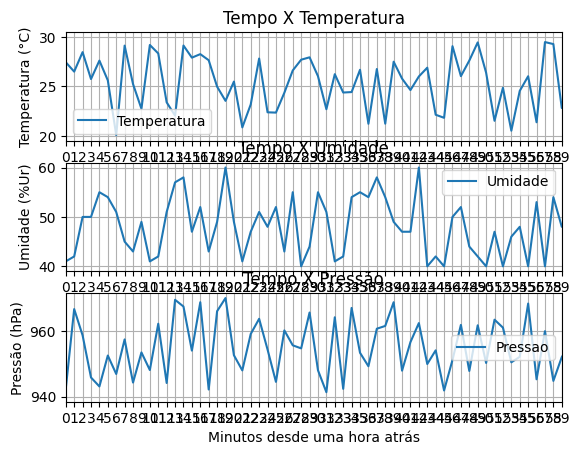

In [35]:
# EXIBIÇÃO DE DADOS

# Seleção do período para visualização dos dados
periodo = "Minutos / Ultima hora" #@param ["Segundos / Sempre", "Minutos / Ultima hora", "Horas / Ultimo dia", "Dias / Ultima semana"]

# Leitura do arquivo CSV
df = pd.read_csv('dadosClimaticosGrupoZ.csv', sep=';').drop(columns=["Altitude"])
# Mostra o head do dataframe
print(df.head())

# Dicionário para conversão de segundos para o período selecionado
dict_periodo = {
    "Segundos / Sempre": [1, 60, "Segundos desde um minuto atrás"], # Não é necessário agrupar os dados
    "Minutos / Ultima hora": [60, 60, "Minutos desde uma hora atrás"],
    "Horas / Ultimo dia": [3600, 24, "Horas desde um dia atrás"],
    "Dias / Ultima semana": [86400, 7, "Dias desde uma semana atrás"]
}

# Agrupamento dos dados de acordo com o período selecionado
# Se não houver dados suficientes para o período selecionado, exibe uma mensagem de erro
if df.shape[0] < dict_periodo[periodo][0]*dict_periodo[periodo][1]:
    print("Não há dados suficientes para o período selecionado!")
    exit()
# O agrupamento é feito pela média dos dados de cada período
df_periodo = df.groupby(df.index // dict_periodo[periodo][0]).mean().tail(dict_periodo[periodo][1])
# Remove a coluna "Timestamp"
df_periodo = df_periodo.drop(columns=["Timestamp"])
# Cria uma coluna com o tempo em minutos/horas/dias
df_periodo = df_periodo.reset_index(drop=True)
    
# Mostra o head do dataframe
# print(df_periodo)
    
fig, axs = plt.subplots(3, 1)
df.plot(y='Temperatura', ax=axs[0], title="Tempo X Temperatura", xlabel="", ylabel="Temperatura (°C)", xlim=[0,dict_periodo[periodo][1]-1], grid=True, xticks=range(0,dict_periodo[periodo][1]), figsize=(25,10))
df.plot(y='Umidade', ax=axs[1], title="Tempo X Umidade", xlabel="", ylabel="Umidade (%Ur)", xlim=[0,dict_periodo[periodo][1]-1], grid=True, xticks=range(0,dict_periodo[periodo][1]), figsize=(25,10))
df.plot(y='Pressao', ax=axs[2], title="Tempo X Pressão", xlabel="", ylabel="Pressão (hPa)", xlim=[0,dict_periodo[periodo][1]-1], grid=True, xticks=range(0,dict_periodo[periodo][1]), figsize=(25,10))
fig_manager = plt.get_current_fig_manager()
plt.show()

In [26]:
print(df_periodo)

    Temperatura
0     25.031150
1     25.201767
2     24.221567
3     24.871050
4     25.206750
5     24.601250
6     24.840267
7     25.067517
8     25.053133
9     24.712617
10    24.573500
11    25.029100
12    25.040767
13    24.673567
14    24.918667
15    24.778117
16    24.323000
17    25.278250
18    25.397550
19    24.469217
20    25.207533
21    25.513233
22    24.765817
23    25.068933
24    25.010900
25    25.461783
26    25.271433
27    24.890817
28    25.042917
29    25.132317
30    24.470750
31    24.971333
32    24.653267
33    24.868383
34    24.848950
35    24.897933
36    24.926550
37    24.783850
38    24.880867
39    25.054200
40    25.499083
41    24.840683
42    25.000683
43    25.088117
44    25.063617
45    25.541983
46    24.939617
47    24.631717
48    25.004383
49    24.617200
50    24.404417
51    24.215183
52    25.452917
53    24.807650
54    24.812300
55    24.956850
56    24.535800
57    24.701800
58    24.370367
59    25.158467


C:\Users\Victor\AppData\Local\Temp\ipykernel_15036\2144187818.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.figure(figsize=(60,10)).show()


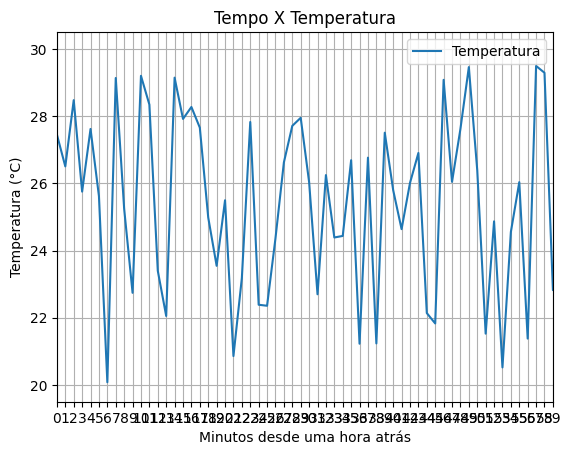

<Figure size 6000x1000 with 0 Axes>

In [34]:
df.plot(y='Temperatura', title="Tempo X Temperatura", xlabel=dict_periodo[periodo][2], ylabel="Temperatura (°C)", xlim=[0,dict_periodo[periodo][1]-1], grid=True, xticks=range(0,dict_periodo[periodo][1]))
#df.plot(y='Umidade', ax=axs[1], title="Tempo X Umidade", xlabel=dict_periodo[periodo][2], ylabel="Umidade (%Ur)")
#df.plot(y='Pressao', ax=axs[2], title="Tempo X Pressão", xlabel=dict_periodo[periodo][2], ylabel="Pressão (hPa)")
plt.figure(figsize=(60,10)).show()
plt.show()